## Metabolomics Workbench integration

Download and process workbench studies

In [3]:
import requests
import pandas as pd
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import libchebipy

In [87]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import networkx as nx
import glob
import sspa

refmet = pd.read_csv('refmet.csv', dtype=object)
name2class = dict(zip(refmet[' refmet_name'], refmet['super_class']))

class WorkbenchDataset:
    '''AN003284.csv
    Class to process Metabolomics Workbench datasets
    '''

    def __init__(self, study_id, md_filter, name, outliers=None, remove_suffix=None, pathway_level=False):
        self.study_id = study_id
        self.md_filter = md_filter
        self.raw_data = None
        self.outliers = outliers
        self.pathway_level = pathway_level
        self.pathway_coverage = None
        self.pathway_data = None
        self.DA_metabolites = None
        self.node_name = study_id
        self.remove_suffix = remove_suffix
        self.name = name
        self.compound_classes = None

        self.read_data()
        # self.get_pathway_data()
        self.da_testing()

    def read_data(self):
        # check if there are multiple files in folder
        files = glob.glob('Studies/'+self.study_id+'/*.csv')
        if len(files) > 1:
            # read in all files and concatenate
            dfs = []
            dfs_proc = []
            for f in files:
                df = pd.read_csv(f)
                dfs.append(df)
                df.index = df['Samples']
                self.raw_data = df

                df_proc = self.preprocess_data()
                dfs_proc.append(df_proc)

            self.raw_data = pd.concat(dfs, axis=1)
            self.processed_data = pd.concat(dfs_proc, axis=1)
            self.processed_data = self.processed_data.loc[:, ~self.processed_data.columns.duplicated()]
            # move group column to end
            cols = [col for col in self.processed_data.columns if col != 'Group'] + ['Group']
            self.processed_data = self.processed_data[cols]

        else:
            data = pd.read_csv(files[0])
            data.index = data['Samples']
            self.raw_data = data

            data_proc = self.preprocess_data()
            self.processed_data = data_proc


        metadata = self.raw_data['Class']
        self.metadata = metadata

        return self.processed_data, self.metadata
    
    def preprocess_data(self):
        '''Preprocess data'''
        data_filt = self.raw_data.copy()
        # drop duplicate columns

        # filter on metadata
        md_dict = dict(zip(self.raw_data['Samples'], self.raw_data['Class']))
        data_filt = data_filt[data_filt['Class'].isin(self.md_filter.values())]
        data_filt = data_filt.drop(columns=['Class', 'Samples'])

        # convert to refmet id
        mets_url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/repl/metabolites'
        mets = requests.get(mets_url.replace('repl', self.study_id)).text
        mets_df = pd.read_json(mets).T
        mets_dict = dict(zip(mets_df['metabolite_name'], mets_df['refmet_name']))
        data_filt.columns = data_filt.columns.map(mets_dict)

        # drop na column names
        data_filt = data_filt.loc[:, data_filt.columns.notna()]

        try:
            data_filt = data_filt.drop(columns=[''])
        except KeyError:
            pass

        # drop outliers
        if self.outliers:
            data_filt = data_filt.drop(self.outliers)

        # Missingness checks 
        # replace empty strings with NaN
        data_filt = data_filt.replace(['', ' ', 0], np.nan)
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        # Delete rows and columns where all values are 0 
        data_filt = data_filt.loc[:, (data_filt != 0).any(axis=0)]
        data_filt = data_filt.loc[(data_filt != 0).any(axis=1), :]

        data_filt = data_filt.dropna(axis=1, thresh=0.5*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
        print(f"Missingness: {missing_pct:.2f}%")

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        data_scaled['Group'] = data_scaled.index.map(md_dict)

        # self.processed_data = data_scaled
        self.compound_classes = {k: name2class[k] if k in name2class.keys() else None for k in data_scaled.columns[:-1]}

        return data_scaled


    def get_pathway_data(self):
        reactome_paths = sspa.process_gmt(infile='../MetDMN/Reactome_Homo_sapiens_pathways_ChEBI_R88.gmt')
        reactome_dict = sspa.utils.pathwaydf_to_dict(reactome_paths)
        data = self.processed_data

        # convert to pubchem
        pubchem_conv = {k: name2pubchem[k] if k in name2pubchem.keys() else None for k in data.columns[:-1]}
        chebi_ids = {k: pubchem_to_chebi(v) for k, v in pubchem_conv.items()}
        print(chebi_ids)


        # store pathway coverage stats
        cvrg_dict = {k: len(set(data.columns).intersection(set(v))) for k, v in reactome_dict.items()}
        self.pathway_coverage = cvrg_dict

        scores = sspa.sspa_KPCA(reactome_paths).fit_transform(data.iloc[:, :-1])
        scores['Group'] = self.processed_data['Group']
        self.pathway_data = scores
 
    def plot_qc(self):
        # PCA biplot
        pca = PCA(n_components=2).set_output(transform="pandas")
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])
        self.pca = pca_result

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result.iloc[:, 0], y=pca_result.iloc[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = 10 * self.processed_data.shape[1]
        data_long = self.processed_data.melt(id_vars='Group')
        sns.boxplot(data=data_long.iloc[0:normaliser, :], ax=ax2, hue='Group', x='variable', y='value')
        ax2.axhline(0, color='red', linestyle='--')
        plt.show()


    def da_testing(self):

        if self.pathway_level == True:
            dat = self.pathway_data
        else:
            dat = self.processed_data

        # t-test for two groups
        case = self.md_filter['Case']
        control = self.md_filter['Control']
        
        stat, pvals = stats.ttest_ind(dat[dat['Group'] == case].iloc[:, :-1],
                        dat[dat['Group'] == control].iloc[:, :-1],
                        alternative='two-sided', nan_policy='raise')
        pval_df = pd.DataFrame(pvals, index=dat.columns[:-1], columns=['P-value'])
        pval_df['Stat'] = stat
        pval_df['Direction'] = ['Up' if x > 0 else 'Down' for x in stat]
        self.pval_df = pval_df

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]
        self.full_connection = [(self.node_name, met) for met in self.processed_data.columns[:-1]]



# ID conversion for pathways 
- Convert from REFMET --> Pubchem --> CHEBI

In [57]:
refmet = pd.read_csv('refmet.csv', dtype=object)

In [66]:
name2pubchem = dict(zip(refmet[' refmet_name'], refmet['pubchem_cid']))

In [86]:
name2class = dict(zip(refmet[' refmet_name'], refmet['super_class']))

In [76]:
import requests

def pubchem_to_chebi(pubchem_id):
    url = f"https://www.ebi.ac.uk/unichem/rest/src_compound_id/{pubchem_id}/1/chebi"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None

In [85]:
pubchem_id = '2244'  # Example PubChem ID for Acetaminophen
chebi_id = pubchem_to_chebi(pubchem_id)
print(chebi_id)

None


## COVID

In [88]:
ST002016 = WorkbenchDataset(
    study_id='ST002016',
    md_filter={'Control': 'group:Healthy', 'Case': 'group:COVID_non-acute'},
    name = 'COVID'
)

C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%
Missingness: 0.00%
Number of differentially abundant metabolites: 134


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


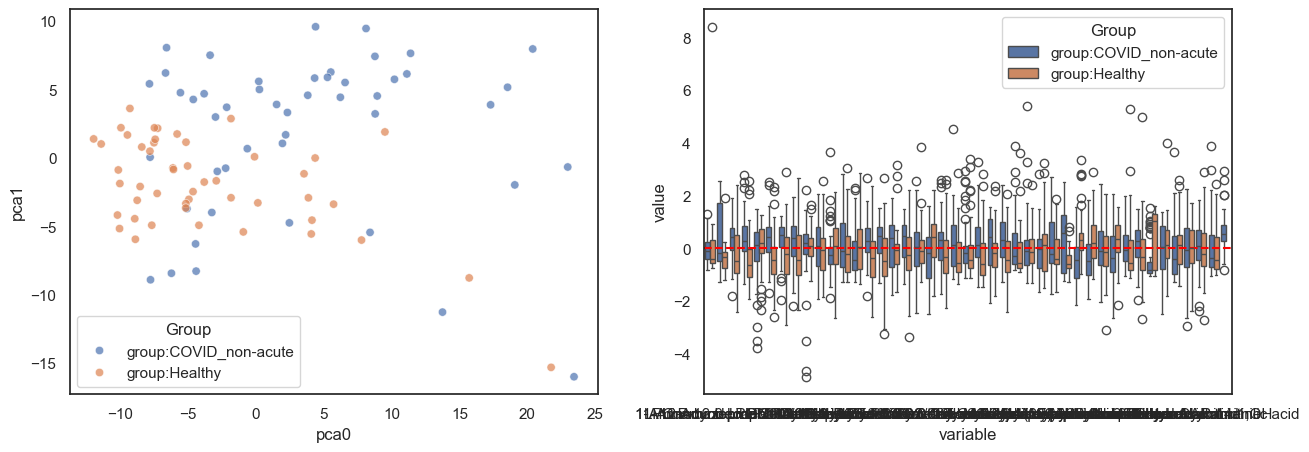

In [89]:
ST002016.plot_qc()

In [91]:
ST002301 = WorkbenchDataset(
    study_id='ST002301',
    name='COVID',
    # filepath='AN003757.csv',
    md_filter={'Control': 'Severity of Disease:Asymptomatic', 'Case': 'Severity of Disease:Severe'})

Missingness: 3.78%
Number of differentially abundant metabolites: 31


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


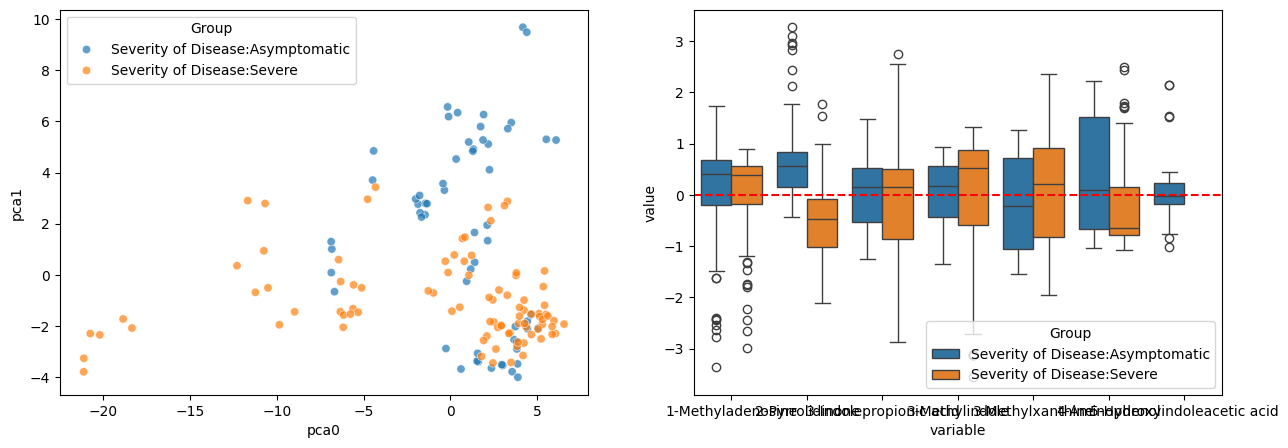

In [7]:
ST002301.plot_qc()

In [92]:
ST001933 = WorkbenchDataset(
    study_id='ST001933',
    name='COVID',
    md_filter={'Control': 'Group:H', 'Case': 'Group:CA'})

Missingness: 2.90%
Number of differentially abundant metabolites: 1


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


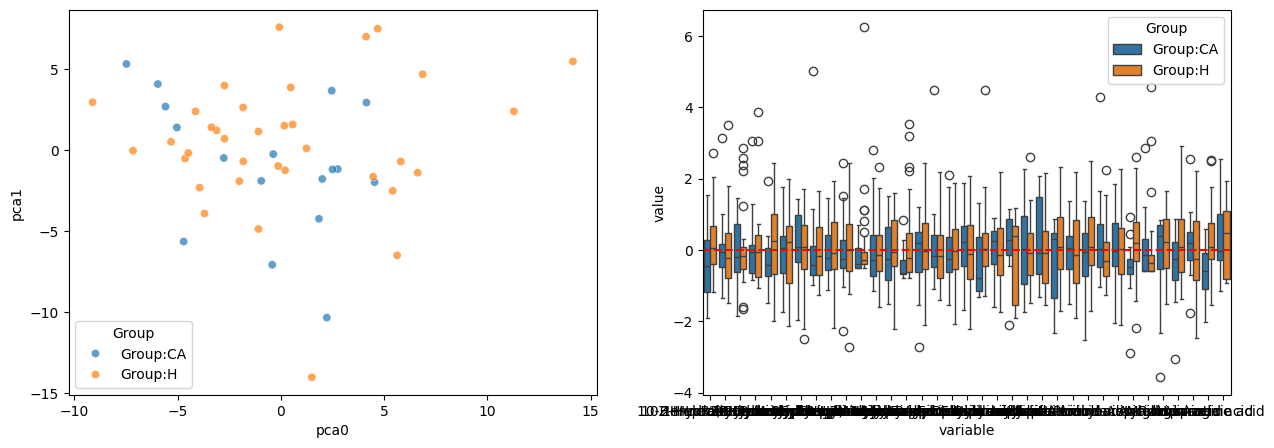

In [11]:
ST001933.plot_qc()

## IBD

In [93]:
ST000899 = WorkbenchDataset(
    study_id='ST000899',
    name='IBD',
    md_filter={'Control': 'Type:Control', 'Case': 'Type:Ulcerative Colitis'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 7.14%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 1.46%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 5.01%
Missingness: 2.80%
Number of differentially abundant metabolites: 0


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


In [13]:
ST000899.processed_data['Group'].value_counts()

Group
Type:Control               20
Type:Ulcerative Colitis    20
Name: count, dtype: int64

In [14]:
ST000899.processed_data.shape   

(40, 519)

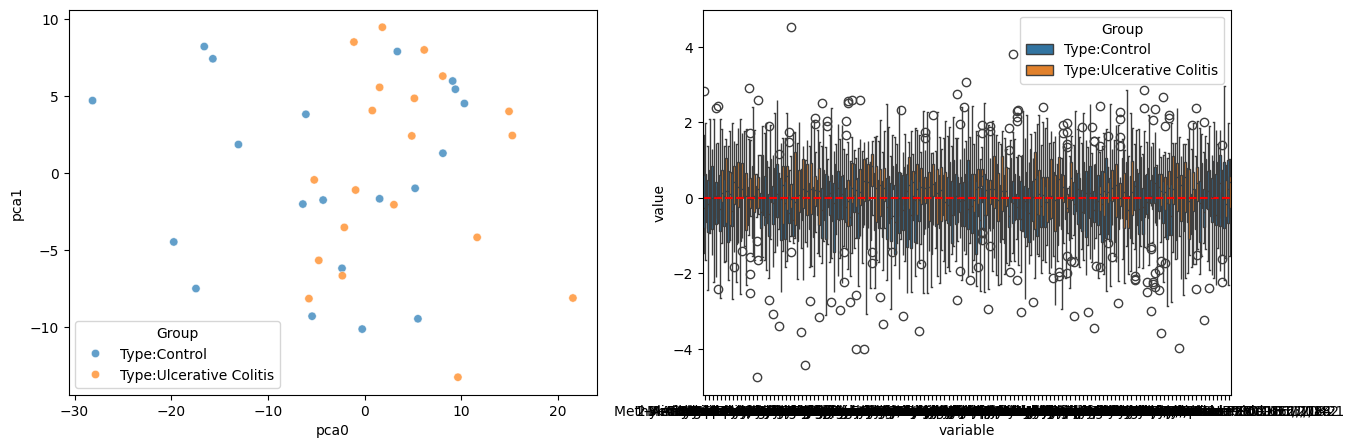

In [15]:
ST000899.plot_qc()

## Cancer

In [94]:
ST000284 = WorkbenchDataset(
    study_id='ST000284',
    name='Colorectal cancer',
    md_filter={'Control': 'Patient group:Healthy', 'Case': 'Patient group:CRC'})

Missingness: 0.00%
Number of differentially abundant metabolites: 7


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


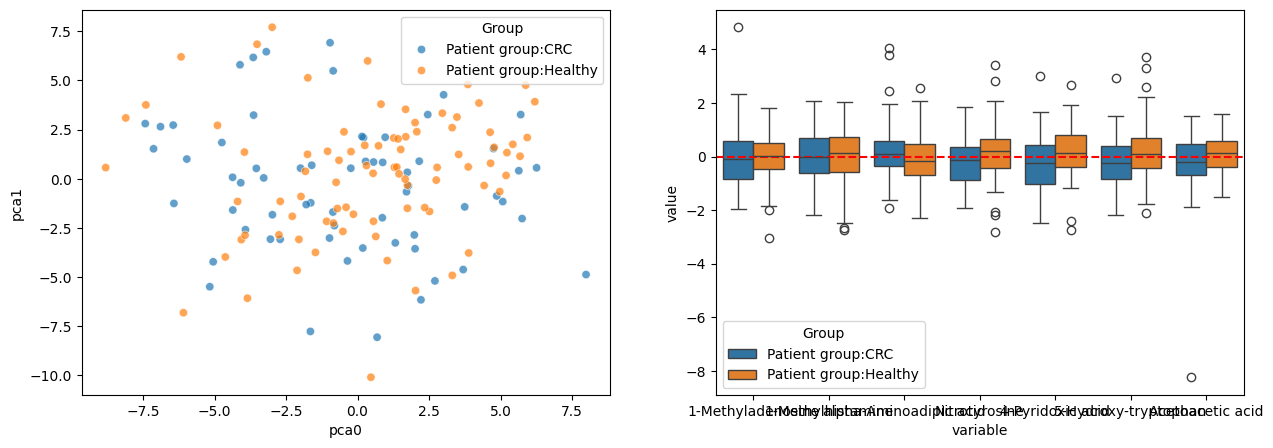

In [17]:
ST000284.plot_qc()

In [41]:
ST000284.processed_data.shape

(148, 102)

In [40]:
ST000284.processed_data['Group'].value_counts()

Group
Patient group:Healthy    84
Patient group:CRC        64
Name: count, dtype: int64

## TB

In [95]:
ST002428 = WorkbenchDataset(
    study_id='ST002428',
    # filepath='AN002826_updated.csv',
    name='Tuberculosis',
    md_filter={'Control': 'Label:Controls', 'Case': 'Label:TB'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 5.27%
Missingness: 4.91%
Number of differentially abundant metabolites: 0


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T
c:\Users\cw2019\.conda\envs\py12\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


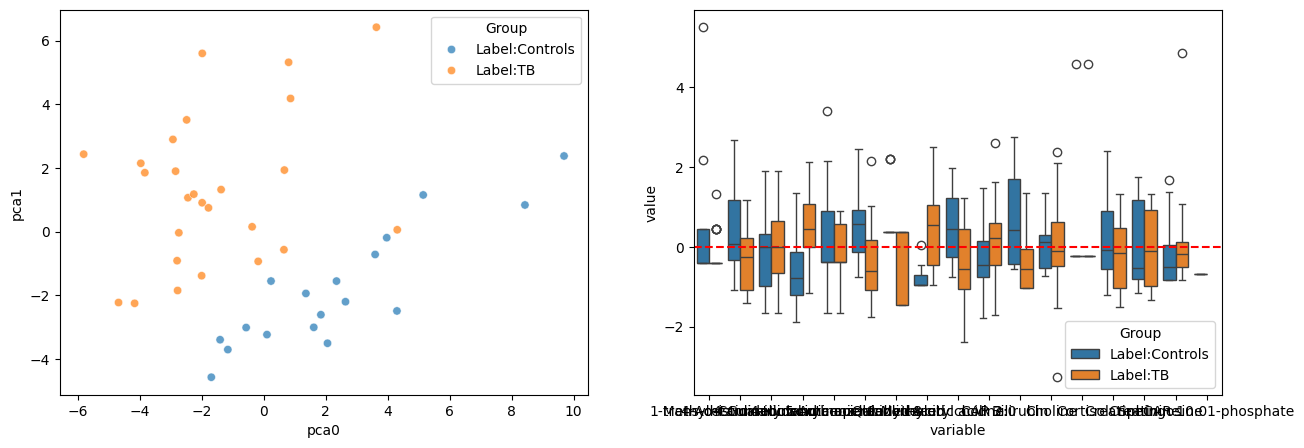

In [19]:
ST002428.plot_qc()

In [125]:
ST002428.processed_data.shape

(44, 71)

In [126]:
ST002428.processed_data['Group'].value_counts()

Group
Label:TB          26
Label:Controls    18
Name: count, dtype: int64

In [20]:
ST002428.pval_df.sort_values(by='P-value')

,P-value,Stat,Direction,FDR_P-value
Tryptophan,1.100015e-07,-6.387464,Down,NaN
9-Methyluric acid,1.866685e-06,5.531845,Up,NaN
Methionine,1.189332e-05,-4.965842,Down,NaN
Hexanoylglycine,1.255960e-05,4.949025,Up,NaN
4-Guanidinobutanoic acid,2.743966e-05,4.706573,Up,NaN
...,...,...,...,...
Pipecolic acid,9.197836e-01,-0.101314,Down,NaN
Glutamine,9.280233e-01,-0.090876,Down,NaN
Isovalerylglycine,9.803711e-01,0.024751,Up,NaN
2-Methylhippuric acid,NaN,NaN,Down,NaN


In [96]:
ST000974 = WorkbenchDataset(
    study_id='ST000974',
    name='TB',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'GROUP:control', 'Case': 'GROUP:case'})

Missingness: 0.26%
Number of differentially abundant metabolites: 1


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T
c:\Users\cw2019\.conda\envs\py12\Lib\site-packages\scipy\stats\_axis_nan_policy.py:563: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


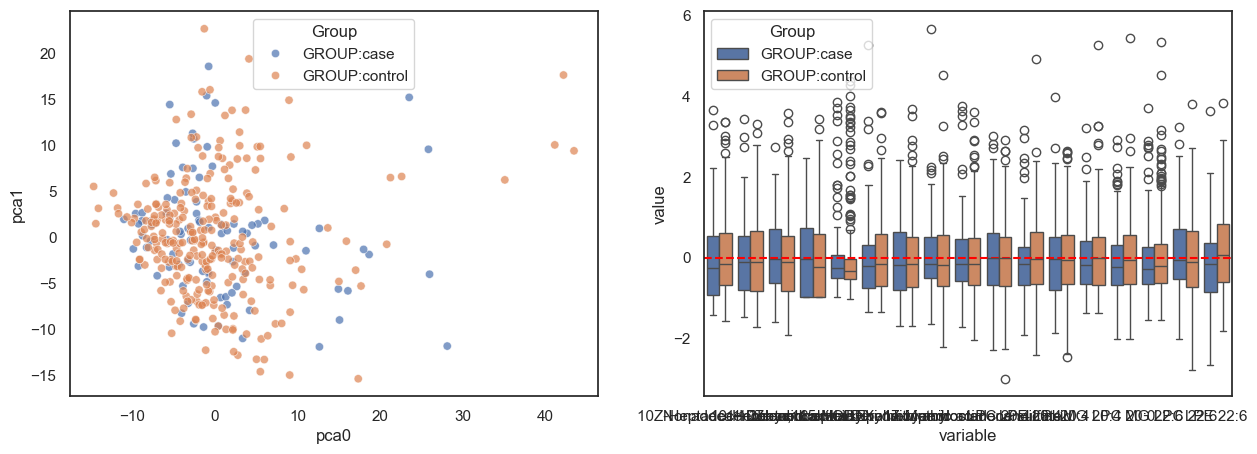

In [457]:
ST000974.plot_qc()


In [43]:
ST000974.processed_data.shape

(366, 603)

In [117]:
ST000974.processed_data.Group.value_counts()

Group
GROUP:control    274
GROUP:case        92
Name: count, dtype: int64

In [44]:
ST000974.raw_data


,Samples,Class,10-heptadecenoate (17:1n7),10-nonadecenoate (19:1n9),10-undecenoate (11:1n1),1-(14 or 15-methyl)palmitoyl-GPC (a17:0 or i17:0)*,11-dehydrocorticosterone,12_13-DiHOME,1_2-propanediol,1_3_7-trimethylurate,...,valyltryptophan,valylvaline,vanillylmandelate (VMA),xanthine,xanthosine,xanthurenate,XHWESASXXR*,xylitol,xylonate,xylose
Samples,,,,,,,,,,,,,,,,,,,,,
MPIIB.2102,MPIIB.2102,GROUP:case,1.66,1.31,0.36,0.54,0.26,1.70,1.59,0.89,...,1.91,1.24,1.57,8.57,1.50,2.49,0.02,1.65,1.43,1.12
MPIIB.2425,MPIIB.2425,GROUP:case,8.87,6.47,2.63,1.06,0.11,0.14,0.91,0.04,...,0.11,0.08,0.88,2.09,0.10,1.04,7.62,0.30,0.68,1.06
MPIIB.3511,MPIIB.3511,GROUP:case,2.88,2.44,4.12,1.30,0.11,0.65,0.59,0.27,...,0.11,0.08,0.74,0.77,1.08,0.12,0.53,1.35,1.11,0.37
MPIIB.4622,MPIIB.4622,GROUP:case,1.19,1.43,0.98,0.78,1.02,1.51,0.79,0.04,...,0.11,0.08,0.64,1.13,0.10,0.12,0.65,0.44,1.10,1.04
MPIIB.8032,MPIIB.8032,GROUP:case,0.96,1.27,0.50,0.23,0.11,0.13,1.00,0.04,...,0.11,0.08,1.48,4.38,2.36,0.12,0.16,1.35,1.09,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MPIIB.6758,MPIIB.6758,GROUP:control,0.62,0.42,0.36,1.00,0.11,4.64,1.23,2.03,...,0.11,0.08,1.01,1.01,1.02,0.12,0.19,0.30,0.82,1.69
MPIIB.7041,MPIIB.7041,GROUP:control,3.18,1.76,1.23,0.79,0.92,2.05,1.19,0.84,...,0.11,0.08,1.06,1.56,1.27,1.16,0.02,1.65,1.16,0.37
MPIIB.7998,MPIIB.7998,GROUP:control,1.99,1.41,1.29,0.44,0.19,0.96,0.54,0.18,...,0.11,0.08,0.80,7.12,1.05,0.12,1.00,0.30,0.20,0.37


## Hepatitis

In [97]:

ST002100 = WorkbenchDataset(
    study_id='ST002100',
    name='Hepatitis',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'Treatment:Healthy', 'Case': 'Treatment:Acute hepatitis'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 0.00%
Missingness: 0.00%
Number of differentially abundant metabolites: 46


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


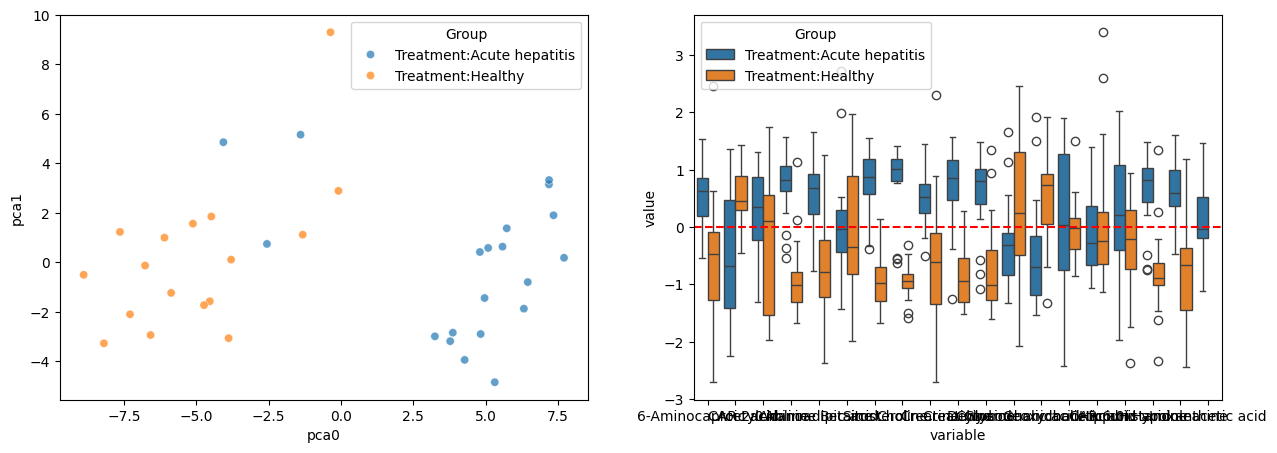

In [24]:
ST002100.plot_qc()

In [47]:
ST002100.processed_data.shape

(37, 68)

In [48]:
ST002100.processed_data['Group'].value_counts()

Group
Treatment:Acute hepatitis    20
Treatment:Healthy            17
Name: count, dtype: int64

## Prostate cancer

In [98]:

ST002498 = WorkbenchDataset(
    study_id='ST002498',
    name='Prostate cancer',
    # filepath='AN002826_updated.csv',
    md_filter={'Control': 'Diagnosis:0', 'Case': 'Diagnosis:1'})

C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 3.46%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 4.58%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 7.70%


C:\Users\cw2019\AppData\Local\Temp\ipykernel_90276\1525690596.py:89: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  mets_df = pd.read_json(mets).T


Missingness: 5.82%
Number of differentially abundant metabolites: 1


In [118]:
ST002498.processed_data.shape

(580, 688)

In [153]:
ST002498.processed_data.Group.value_counts()

Group
Diagnosis:0    313
Diagnosis:1    267
Name: count, dtype: int64

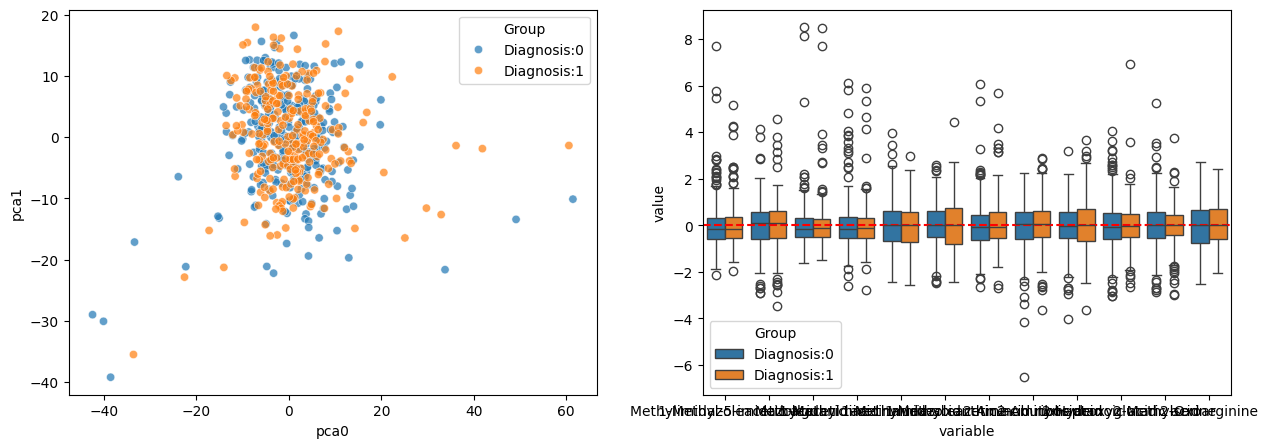

In [26]:
ST002498.plot_qc()

In [27]:
ST002498.pval_df.sort_values(by='P-value')

,P-value,Stat,Direction,FDR_P-value
Succinic acid,0.000002,4.761786,Up,0.001669
Ribitol,0.000554,3.472620,Up,0.190279
Palmitoleic acid,0.005071,2.813248,Up,0.987072
Histidine,0.008854,2.626568,Up,0.987072
Glucuronic acid,0.012037,2.519029,Up,0.987072
...,...,...,...,...
Pro-hydroxyPro,0.991792,-0.010292,Down,0.997221
Glycodeoxycholic acid 3-sulfate,0.992867,-0.008944,Down,0.997221
Glycochenodeoxycholic acid 3-glucuronide,0.994665,-0.006689,Down,0.997569
Phosphoethanolamine,0.997975,0.002539,Up,0.998504


# Network

In [119]:
studies = [ST002016, ST002301, ST001933, ST000899, ST000284, ST002100, ST000974, ST002428, ST002498]


In [122]:
len(studies)

9

In [100]:
def get_bipartite(studies):
    B = nx.Graph()
    # Add nodes with the node attribute "bipartite"-

    B.add_nodes_from([i.node_name for i in studies], bipartite=0)
    B.add_nodes_from(sum([i.DA_metabolites for i in studies], []), bipartite=1)
    # Add edges only between nodes of opposite node sets
    B.add_edges_from(sum([i.full_connection for i in studies], []))
    bottom_nodes, top_nodes = bipartite.sets(B)
    nx.is_connected(B)
    return B, bottom_nodes, top_nodes


In [146]:
for i in studies:
    print(i.node_name, len(i.DA_metabolites))

ST002016 134
ST002301 31
ST001933 1
ST000899 0
ST000284 7
ST002100 46
ST000974 1
ST002428 0
ST002498 1


In [120]:


covid_bpt, covid_bottom_nodes, covid_top_nodes = get_bipartite(studies)


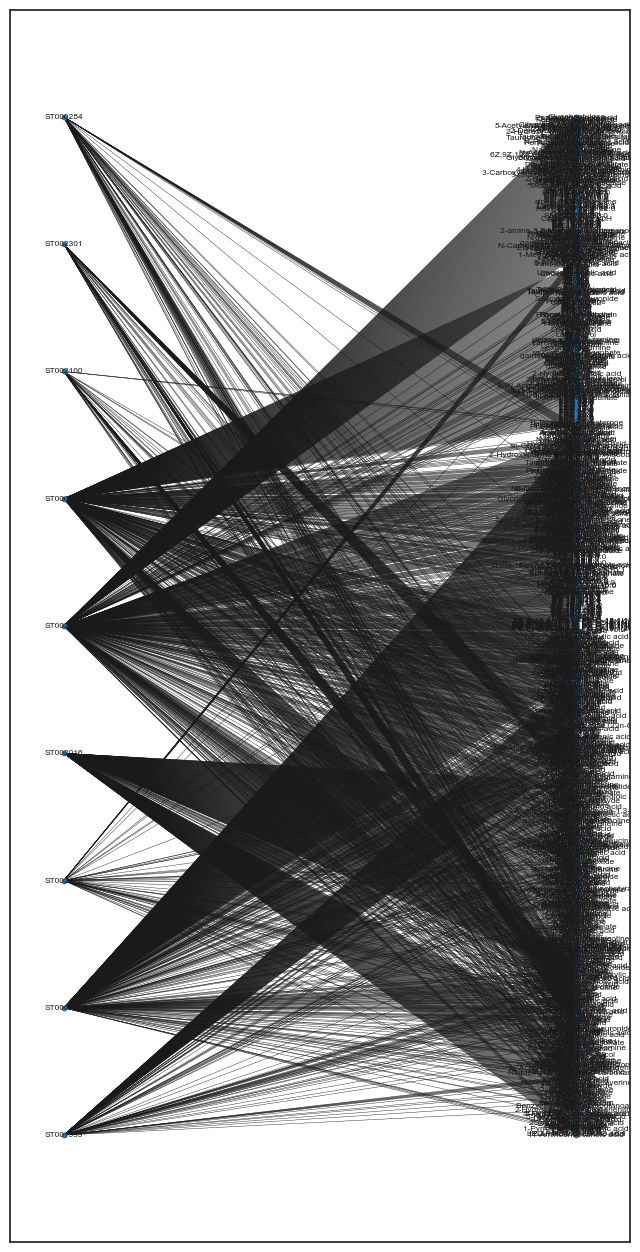

In [121]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    covid_bpt,
    pos = nx.drawing.layout.bipartite_layout(covid_bpt, covid_bottom_nodes),
    font_size=6,
    width = 0.3,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()


In [123]:
study_labels = dict(zip([i.node_name for i in studies], [i.name for i in studies]))

ST002016
ST002301
ST001933
ST000899
ST000284
ST002100
ST000974
ST002428
ST002498


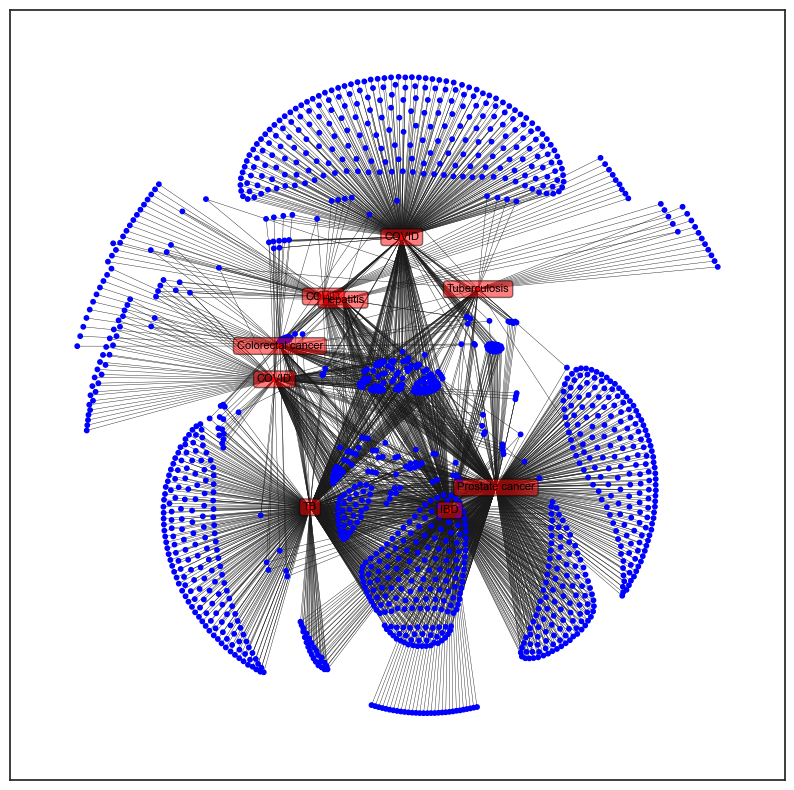

In [127]:

# force directed layout
pos = nx.drawing.layout.kamada_kawai_layout(covid_bpt)
color_map = []
labels = {}
for node in covid_bpt:
    if node in covid_bottom_nodes:
        print(node)
        color_map.append('red')
        labels[node] = study_labels[node]
    else: 
        color_map.append('blue')    
        # labels[node] = ''  


plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    covid_bpt,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) # Or whatever other display options you like
nx.draw_networkx_labels(covid_bpt, pos, labels,
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_size=8,
                        font_color='black')

plt.show()

In [128]:
biadj_mat = nx.bipartite.biadjacency_matrix(covid_bpt, row_order=covid_bottom_nodes, column_order=covid_top_nodes).toarray()

# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat = pd.DataFrame(biadj_mat @ biadj_mat.T, index=list(covid_bottom_nodes), columns=list(covid_bottom_nodes))


c:\Users\cw2019\.conda\envs\py12\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


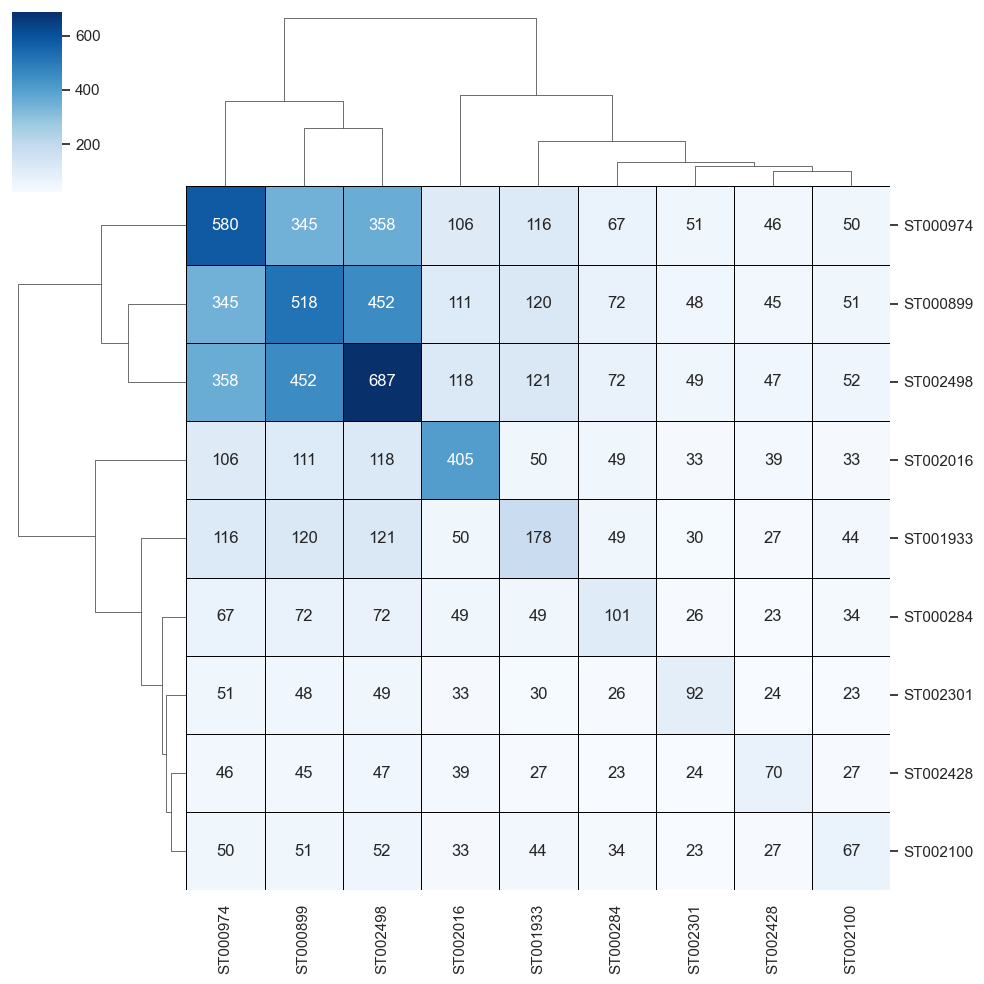

In [129]:

# fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style='white')
sns.clustermap(
    adj_mat, 
    cmap='Blues', 
    square=True, 
    annot=True, 
    # cbar=False, 
    fmt='d', 
    linewidths=0.5, 
    linecolor='black' )
# ax.set_yticklabels(bottom_nodes, rotation=0)
# ax.set_xticklabels(bottom_nodes, rotation=90)
# ax.set_title('Similarity matrix of differential metabolites')
# plt.tight_layout()
plt.show()


In [130]:

# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat_dmn = pd.DataFrame(biadj_mat.T @ biadj_mat, index=list(covid_top_nodes), columns=list(covid_top_nodes))


# make pandas edgelist
edgelist_dmn = adj_mat_dmn.stack().reset_index()
edgelist_dmn.columns = ['source', 'target', 'weight']
edgelist_dmn = edgelist_dmn[edgelist_dmn['weight'] > 1]


In [131]:
edgelist_dmn.sort_values('weight', ascending=False)

,source,target,weight
64975,Valine,Glutamine,9
965855,Glutamine,Tryptophan,9
1257879,Tryptophan,Histidine,9
965526,Glutamine,Histidine,9
1695172,Arginine,Valine,9
...,...,...,...
339313,PC P-16:0/16:1 or PC O-16:1/16:1,Pyroglutamic acid,2
339310,PC P-16:0/16:1 or PC O-16:1/16:1,3-Carboxy-4-methyl-5-propyl-2-furanpropanoic acid,2
339309,PC P-16:0/16:1 or PC O-16:1/16:1,p-Cresol sulfate,2
339308,PC P-16:0/16:1 or PC O-16:1/16:1,Erythronic acid,2


In [132]:
edgelist_dmn.sort_values('weight', ascending=False)
dmn_graph = nx.from_pandas_edgelist(edgelist_dmn, edge_attr='weight')
dmn_graph.remove_edges_from(nx.selfloop_edges(dmn_graph))
nx.set_node_attributes(dmn_graph, dict(dmn_graph.degree()), 'degree')

print(dmn_graph.number_of_nodes())
print(dmn_graph.number_of_edges())


608
133169


In [133]:
biadj_mat_df = pd.DataFrame(biadj_mat, index=list(covid_bottom_nodes), columns=list(covid_top_nodes))
study_contributions = biadj_mat_df.divide(biadj_mat_df.sum(axis=0), axis=1)
# add contribution from each study 
nx.set_node_attributes(dmn_graph, study_contributions.to_dict())

# normalise by the number of studies



In [134]:
# add chemical classes
chem_dicts = [i.compound_classes for i in studies]
chem_classes = {k: v for d in chem_dicts for k, v in d.items()}
nx.set_node_attributes(dmn_graph, chem_classes, 'superclass')

In [143]:
# check if any node attributes are none
none_nodes = [k for k, v in nx.get_node_attributes(dmn_graph, 'superclass').items() if v is None]

# replace none with unknown
for node in none_nodes:
    dmn_graph.nodes[node]['superclass'] = 'Unknown'


In [142]:
none_nodes

['Taurolithocholic acid sulfate',
 'Sulfoglycolithocholic acid',
 'Hexanoylglutamine',
 'N-Stearoyl taurine',
 'N-Palmitoyl glycine',
 'N-linoleoylglycine',
 'N-Oleoyl taurine',
 'Hexanoylglycine',
 'Capryloylglycine']

In [144]:
# export network
nx.write_graphml(dmn_graph, 'workbench_network_full.graphml')

# Pathway level similarity network

### Overlap between studies

In [113]:
studies = [ST002016, ST002301, ST001933, ST000899, ST000284, ST002100]

In [77]:
# look at overlap of metabolites between studies

overlap = pd.DataFrame(
    np.zeros((len(studies), len(studies))), 
    index=[i.node_name for i in studies], 
    columns=[i.node_name for i in studies]
)

for i in range(len(studies)):
    for j in range(len(studies)):
        overlap.iloc[i, j] = len(set(studies[i].processed_data.iloc[:, :-1].columns) & set(studies[j].processed_data.iloc[:, :-1].columns))


c:\Users\cw2019\.conda\envs\py12\Lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


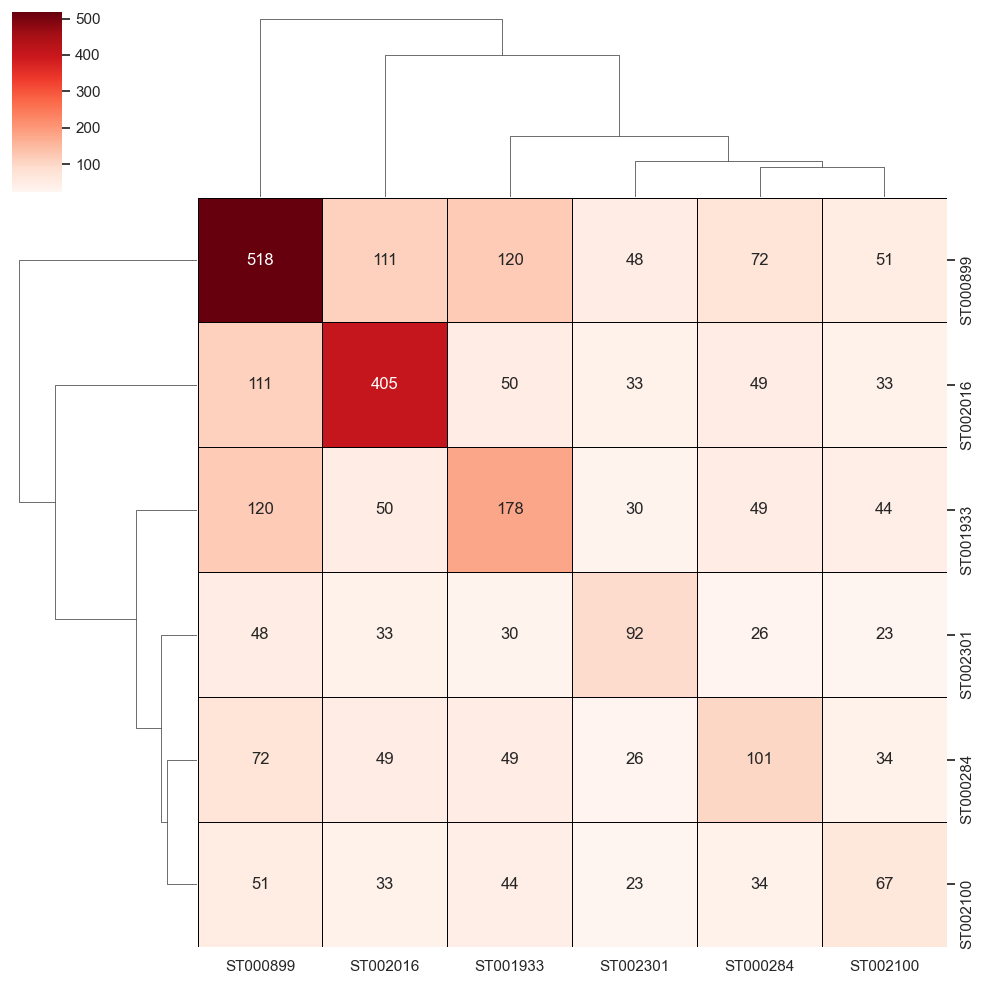

In [78]:

sns.set(style='white')
sns.clustermap(overlap, cmap='Reds', annot=True, square=True, fmt='2g', linewidths=0.5, linecolor='black')
plt.show()

# API searching
- search studies by the number of named metabolites (there might be a lot of lipids anyway
)

In [118]:
url = 'https://www.metabolomicsworkbench.org/rest/study/study_id/ST/named_metabolites/'

In [123]:
resp = requests.get(url).json()

In [125]:
studies_summary = pd.DataFrame.from_dict(resp).T

In [127]:
studies_summary_human = studies_summary[studies_summary['species'] == 'Homo sapiens']

In [137]:
studies_summary_human.sort_values(by='num_metabolites', ascending=False)

,study_id,study_title,institute,analysis_id,analysis_type,units,num_metabolites,details,species
2150,ST002094,Commensal intestinal microbiota regulates host...,Mayo Clinic,AN003420,MS,raw intensity,11992,Reversed phase POSITIVE ION MODE,Homo sapiens
130,ST000148,A549 13C-labeled Cell Study,University of Kentucky,AN000235,MS,normalized corrected Peak area,10352,ESI positive ion mode,Homo sapiens
100,ST000114,SIRM Analysis of human P493 cells under hypoxi...,University of Kentucky,AN000192,MS,Peak area,9007,FTMS positive ion mode,Homo sapiens
3100,ST003040,MM.1S Myeloma tumor cells and tumors made by s...,Mainehealth,AN004987,MS,Corrected Peak intensities,6188,None (Direct infusion) UNSPECIFIED ION MODE,Homo sapiens
101,ST000114,SIRM Analysis of human P493 cells under hypoxi...,University of Kentucky,AN000193,MS,Peak area,4404,FTMS negative ion mode,Homo sapiens
...,...,...,...,...,...,...,...,...,...
3020,ST002923,Gut sphingolipid metabolites in infants with a...,Asan Medical Center,AN004793,MS,pmol/mg,1,Reversed phase NEGATIVE ION MODE,Homo sapiens
1179,ST001069,Evaluation of Seryl-leucine core 1 O-glycosyla...,Colorado State University,AN001750,MS,counts,1,Reversed phase POSITIVE ION MODE/TOF,Homo sapiens
1180,ST001069,Evaluation of Seryl-leucine core 1 O-glycosyla...,Colorado State University,AN001751,MS,counts,1,Reversed phase POSITIVE ION MODE/QTOF,Homo sapiens
892,ST000825,CHEAR Christiani Biocrates,RTI International,AN001313,MS,uM,1,Isocratic NEGATIVE ION MODE,Homo sapiens


In [140]:
studies_summary_human.sort_values(by='num_metabolites', ascending=False).to_csv('WorkbenchHuman_named_mets.csv')

In [135]:
studies_summary_human['num_metabolites'] = studies_summary_human['num_metabolites'].astype(int)

C:\Users\cw2019\AppData\Local\Temp\ipykernel_29584\1943521326.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  studies_summary_human['num_metabolites'] = studies_summary_human['num_metabolites'].astype(int)


<Axes: xlabel='num_metabolites', ylabel='Count'>

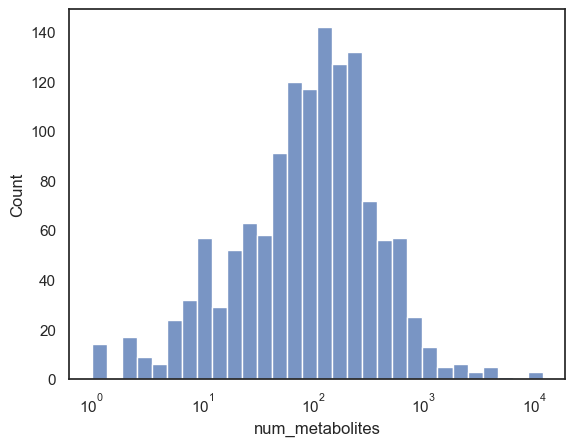

In [139]:
sns.histplot(
    data=studies_summary_human,
    x='num_metabolites',
    log_scale=True
)